model name: EXO_TAO


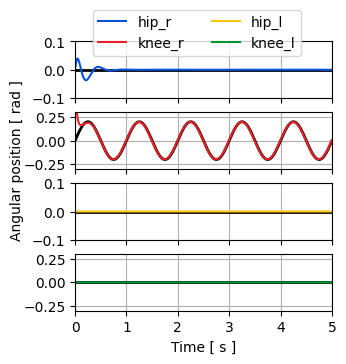

In [1]:
FLAG = {}
FLAG["ANIMATE"] = True
FLAG["SAVE_FIGURE"] = False
FLAG["PLOT_POSITION"] = True
FLAG["PLOT_INTERACTIVE"] = True
FLAG["PD_CONTROL"] = True
FLAG["FF_GRAVITY"] = True
FLAG["FF_FULL"]    = True

CONFIG = {}
CONFIG['dt'] = 1/200
CONFIG['fps'] = 30

import pinocchio as pin
from pinocchio.utils import *
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import os
import time
from panda3d_viewer import ViewerClosedError
from pinocchio.visualize.panda3d_visualizer import Panda3dVisualizer

import sympy as sym

t_sym = sym.Symbol('t')

y1 = .2*sym.sin(2*np.pi*t_sym)
y1_d = sym.diff(y1)
y1_dd = sym.diff(y1_d)

fnc_q_des = sym.lambdify(t_sym,y1)
fnc_qd_des = sym.lambdify(t_sym,y1_d)
fnc_qdd_des = sym.lambdify(t_sym,y1_dd)

robot = pin.RobotWrapper()
robot.initFromURDF("Exo/description_v1.urdf")

print('model name: ' + robot.model.name)
 
# Sample a random configuration
q         = zero(robot.model.nv) ; q = np.array([0,.5,0,0])
qd        = zero(robot.model.nv) ;
qdd       = zero(robot.model.nv) ;

q_des     = zero(robot.model.nv) ;
qd_des    = zero(robot.model.nv) ;
qdd_des   = zero(robot.model.nv) ;

tau       = zero(robot.model.nv) ;
tauPD     = zero(robot.model.nv) ;
tauFF     = zero(robot.model.nv) ;
tauG      = zero(robot.model.nv) ;

robot.forwardKinematics(q)

dt = CONFIG['dt']

t = np.linspace(0,5,int(5/dt))
log_q       = np.empty((4,t.shape[0]))
log_q_des   = np.empty((4,t.shape[0]))

for i,t_cur in enumerate(t):

    
    q_des[1] = fnc_q_des(t_cur)
    qd_des[1] = fnc_qd_des(t_cur)
    qdd_des[1] = fnc_qdd_des(t_cur)

    q_des[3] = fnc_q_des(t_cur)
    qd_des[3] = fnc_qd_des(t_cur)
    qdd_des[3] = fnc_qdd_des(t_cur)

    robot.nle(q,qd)
    robot.mass(q)       
    robot.computeJointJacobians(q)

    pin.computeAllTerms(robot.model,robot.data,q,qd)
    
    M = robot.mass(q)
    h = robot.nle(q, qd)          
    g = robot.gravity(q)
    
    if FLAG.get("PD_CONTROL",False):
        tauPD = 100*(q_des-q) + 5*(qd_des-qd)
    else:
        tauPD = zero(robot.model.nv)
    
    if FLAG.get("FF_GRAVITY",False):
        tauG  = g
    else:
        tauG   = zero(robot.model.nv)

    if FLAG.get("FF_FULL",False):
        tauFF = M.dot(qdd_des+tauPD)
    else:
        tauFF = zero(robot.model.nv)
    

    tau = tauPD + tauFF + tauG
    tau *= [0,1,1,1]
    # tau *= [0,0,0,0]
    
    
    M_inv = np.linalg.inv(M)
    
    qdd = M_inv.dot(tau-h)  
    qd = qd + qdd*dt  
    q = q + dt*qd  + 0.5*dt*dt*qdd

    log_q      [:,i] = q
    log_q_des  [:,i] = q_des


try:
    if FLAG.get("ANIMATE",False):
        robot.setVisualizer(Panda3dVisualizer())
        robot.initViewer()
        robot.loadViewerModel(group_name='EXO_TAO', color=(1, 1, 1, 1))
        fpsRatio = int((CONFIG["dt"]*CONFIG["fps"])**-1)
        robot.play(log_q[:,::fpsRatio],fpsRatio*dt)
except:
    None


# if FLAG.get("PLOT_INTERACTIVE",False):
#     %matplotlib qt

if FLAG.get("PLOT_POSITION",False):
    
    fig,ax = plt.subplots(robot.model.nv)

    cm = 1/2.54
    
    ratioxy = (.75,.8)
    offxy = (0.2,0.15)
    dxy = (1,(.95-offxy[1])/len(ax))
    ylims = (np.array([-1,1])*.1,
             np.array([-1,1])*.3,
             np.array([-1,1])*.1,
             np.array([-1,1])*.3)
    colors = ("#0652DD",
              "#EA2027",
              "#FFC312",
              "#009432")

    labels = (r"hip_r",r"knee_r",r"hip_l",r"knee_l")

    lines = []

    fig.set_size_inches(8.7*cm,9*cm)
    for joint in range(len(ax)):
        ax[joint].plot(t,log_q_des[joint,:],c="#000",lw=2,alpha=1)
        p1 = ax[joint].plot(t,log_q[joint,:],c=colors[joint])
        p1[0].set_label(labels[joint])
        lines.append(p1[0])
        ax[joint].set_ylim(ylims[joint])
        ax[joint].set_xlim(np.array([0,t[-1]]))
                    
        if(joint==3):
            ax[joint].set_xlabel("Time [ s ]")
        else:
            ax[joint].set_xticklabels(())
                   
        ax[joint].set_position([offxy[0],offxy[1]+(len(ax)-joint-1)*dxy[1],dxy[0]*ratioxy[0],dxy[1]*ratioxy[1]])
        ax[joint].grid(True)

txt = fig.text(0,0,"Angular position [ rad ]",
                rotation=90,
                position=(0.01,offxy[1]+(1-offxy[1])/2),
                horizontalalignment="left",
                verticalalignment="center")
# lg = fig.legend(("Desired","Measured"),ncols=2,loc='lower center')


lg = fig.legend(ncols=2,loc='lower center')
lg.set_bbox_to_anchor((offxy[0]+ratioxy[0]/2,.85))

figname="Figs/Fig"
if FLAG.get("PD_CONTROL",False):
    figname+="_PD"
if FLAG.get("FF_GRAVITY",False):
    figname+="_FF_G"
if FLAG.get("FF_FULL",False):
    figname+="_FF_F"
figname+=".png"
if FLAG.get("SAVE_FIGURE",False):
    fig.savefig(figname,dpi=1000)

In [2]:
fpsRatio = int((CONFIG["fps"]*CONFIG["dt"])**-1)
print(fpsRatio)

6
